# Imports

In [1]:
from phenoseeker import BioproxyEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.pyplot as plt
from pingouin import compute_effsize
import numpy as np


# get data

In [2]:
base_path = Path("/home/maxime/data/jump_embeddings/dinov2_g/compounds/")
npy_file = base_path  / "Embeddings_norm.npy"
parquet_metadata = base_path  / Path("metadata.parquet")

In [35]:
model = "dinov2_g"
base_path = Path("/projects/synsight/data/jump_embeddings/compounds_embeddings/")
npy_file = base_path / model / "Embeddings_norm.npy"
parquet_metadata = base_path / model / Path("metadata.parquet")

In [36]:
screens_folders = {
      #  "ChemBL": Path("/projects/synsight/repos/phenospace/bioproxy/screens_data_chembl"),
        "Curie": Path("/projects/synsight/repos/phenospace/bioproxy/screens_data_curie"),
        "ChEMBL": Path("/projects/synsight/repos/phenoseeker/data/ChEMBL/assays_csv"),
        "Lit-PCBA": Path("/projects/synsight/repos/phenoseeker/data/Lit_PCBA/csv_files"),
}

In [37]:
eval = BioproxyEvaluator(parquet_metadata, npy_file, screens_folders, embeddings_name='Embeddings_dinov2', embeddings_entity='compound')

In [38]:
     
for source in eval.screen_embedding_managers.keys():
    print(source)
    for screen in tqdm(eval.screen_embedding_managers[source].keys()):
        eval.screen_embedding_managers[source][screen].compute_distance_matrix("Embeddings_dinov2", "cosine")

Curie


100%|██████████| 16/16 [00:02<00:00,  5.93it/s]


ChEMBL


100%|██████████| 49/49 [00:12<00:00,  4.08it/s]


Lit-PCBA


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


# Ranking

## Functions

In [ ]:
def assign_stars(p_value):
    """
    Assign significance stars based on the p-value.
    """
    if p_value < 0.00001:
        return "*****"
    elif p_value < 0.0001:
        return "****"
    elif p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"

def run_normality_test(diff_array):
    """
    Run Shapiro-Wilk normality test on the differences between paired samples.
    
    Parameters:
        diff_array (np.array): Difference between two paired samples.
    
    Returns:
        stat (float): Shapiro-Wilk test statistic.
        p_value (float): p-value from the test.
    """
    stat, p_value = shapiro(diff_array)
    return stat, p_value

def choose_and_run_test(data1, data2, alternative='two-sided', alpha=0.05, zero_method='wilcox'):
    """
    Check normality of differences and run the appropriate paired test.
    
    If the differences are normally distributed (p > alpha from the Shapiro-Wilk test),
    a paired t-test is applied. Otherwise, the Wilcoxon signed-rank test is used.
    
    Parameters:
        data1, data2 (np.array): Paired data arrays.
        alternative (str): Alternative hypothesis ('greater' by default).
        alpha (float): Significance level.
        zero_method (str): Zero method for the Wilcoxon test.
    
    Returns:
        test_name (str): Name of the test used.
        test_statistic (float): Test statistic value.
        p_value (float): p-value from the test.
        norm_p_value (float): p-value from the Shapiro-Wilk normality test.
    """
    differences = data1 - data2
    stat_norm, p_norm = run_normality_test(differences)
    
    if p_norm > alpha:
        # Normality holds, so we use paired t-test.
        test_statistic, p_value = ttest_rel(data1, data2, alternative=alternative)
        test_name = "paired t-test"
    else:
        # Otherwise, we use the nonparametric Wilcoxon signed-rank test.
        test_statistic, p_value = wilcoxon(data1, data2, alternative=alternative, zero_method=zero_method)
        test_name = "Wilcoxon signed-rank test"
    
    return test_name, test_statistic, p_value, p_norm

def compute_effect_size(data1, data2, paired=True):
    """
    Compute Cohen's d for paired samples using the pingouin package.
    
    Parameters:
        data1, data2 (np.array): Paired data arrays.
        paired (bool): Whether the comparison is paired (True by default).
        
    Returns:
        cohen_d (float): Computed Cohen's d effect size.
    """
    return compute_effsize(data1, data2, paired=paired, eftype='cohen')

def run_all_tests(all_means, top_5_means, high_5_means, alpha=0.05):
    """
    Run all statistical tests between the three groups:
    1. High 5% vs. All Means
    2. High 5% vs. Top 5% Means
    3. Top 5% vs. All Means
    
    Parameters:
        all_means, top_5_means, high_5_means (np.array): Arrays of measurements.
        alpha (float): Significance level.
        
    Returns:
        results (dict): A dictionary containing test names, test statistics,
                        p-values, normality p-values, and effect sizes.
    """
    results = {}

    # Comparison 1: High 5% vs. All Means
    test_name1, stat1, p_value1, norm_p1 = choose_and_run_test(high_5_means, all_means, alternative='greater', alpha=alpha)
    cohen_d1 = compute_effect_size(high_5_means, all_means, paired=True)
    results["High_vs_All"] = {
        "Normality_p": norm_p1,
        "Test": test_name1,
        "Test_Statistic": stat1,
        "p_value": p_value1,
        "Cohen_d": cohen_d1
    }
    
    # Comparison 2: High 5% vs. Top 5% Means
    test_name2, stat2, p_value2, norm_p2 = choose_and_run_test(high_5_means, top_5_means, alternative='greater', alpha=alpha)
    cohen_d2 = compute_effect_size(high_5_means, top_5_means, paired=True)
    results["High_vs_Top"] = {
        "Normality_p": norm_p2,
        "Test": test_name2,
        "Test_Statistic": stat2,
        "p_value": p_value2,
        "Cohen_d": cohen_d2
    }
    
    # Comparison 3: Top 5% vs. All Means
    test_name3, stat3, p_value3, norm_p3 = choose_and_run_test(top_5_means, all_means, alternative='greater', alpha=alpha)
    cohen_d3 = compute_effect_size(top_5_means, all_means, paired=True)
    results["Top_vs_All"] = {
        "Normality_p": norm_p3,
        "Test": test_name3,
        "Test_Statistic": stat3,
        "p_value": p_value3,
        "Cohen_d": cohen_d3
    }
    
    return results

def plot_results(all_means, top_5_means, high_5_means, labels, colors, results, scatter=True):
    """
    Generate a box plot with overlaid scatter points for the three groups and
    add significance stars based on pairwise comparisons.
    
    Parameters:
        all_means, top_5_means, high_5_means (np.array): Data arrays.
        labels (list): List of group labels (e.g., ['All', 'Top 5%', 'High 5%']).
        colors (list): List of colors for each group.
        results (dict): Output from run_all_tests, containing statistical test results.
        scatter (bool): To plot or not to plot individual data values.
    """
    data = [all_means, top_5_means, high_5_means]
    
    # Determine significance stars based on p-values from the tests.
    significance_top_vs_all = assign_stars(results["Top_vs_All"]["p_value"])
    significance_high_vs_top = assign_stars(results["High_vs_Top"]["p_value"])
    
    plt.figure(figsize=(4, 10))
    box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)

    # Color the boxes.
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    if scatter:
        # Overlay scatter points for individual data values.
        for i, (dataset, color) in enumerate(zip(data, colors), start=1):
            plt.scatter([i] * len(dataset), dataset, color=color, alpha=0.7, edgecolor='k')

    # Calculate y-levels for significance annotations.
    y_max_all_top5 = max(np.max(all_means), np.max(top_5_means)) + 0.01
    y_max_top5_high5 = max(np.max(top_5_means), np.max(high_5_means))
    h = 0.01  # Height offset for significance lines.
    star_offset = 0.002

    # Add significance line and stars between All and Top 5%.
    x1, x2 = 1, 2
    plt.plot([x1, x1, x2, x2],
             [y_max_all_top5, y_max_all_top5 + h, y_max_all_top5 + h, y_max_all_top5],
             lw=1.5, color='black')
    plt.text((x1 + x2) * 0.5, y_max_all_top5 + h + star_offset,
             significance_top_vs_all, ha='center', fontsize=12)
    
    # Add significance line and stars between Top 5% and High 5%.
    x1, x2 = 2, 3
    plt.plot([x1, x1, x2, x2],
             [y_max_top5_high5 + h, y_max_top5_high5 + 2 * h, y_max_top5_high5 + 2 * h, y_max_top5_high5 + h],
             lw=1.5, color='black')
    plt.text((x1 + x2) * 0.5, y_max_top5_high5 + 2 * h + star_offset,
             significance_high_vs_top, ha='center', fontsize=12)
    
    plt.ylabel('Tanimoto Similarity')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.03, 0.47)
    plt.show()

In [8]:
def get_tanimono(df):
    inchi_list = df["Metadata_InChI"].tolist()
    tanimoto = []
    mols = [Chem.MolFromInchi(inchi) for inchi in inchi_list]
    gen = GetMorganGenerator(radius=2, fpSize=2048)
    fps = [gen.GetFingerprint(mol) for mol in mols]
    for fp in fps:
        sim = DataStructs.TanimotoSimilarity(fps[0], fp)
        tanimoto.append(sim)
    return tanimoto

In [9]:
def calculate_sims(df):
    df_excluded = df.iloc[1:]
    n_first_5_percent = int(len(df_excluded) * 0.05) + 1
    mean_tanimoto_first_5_percent = df_excluded.nsmallest(n_first_5_percent, 'Distance')['tanimoto_to_target'].mean()
    mean_tanimoto_last_5_percent = df_excluded.nlargest(n_first_5_percent, 'tanimoto_to_target')['tanimoto_to_target'].mean()
    mean_tanimoto_all = df_excluded['tanimoto_to_target'].mean()
    return mean_tanimoto_first_5_percent, mean_tanimoto_last_5_percent, mean_tanimoto_all

In [10]:

def get_sims(source, screen, eval):
    df_inchi = eval.screen_embedding_managers[source][screen].df[['Metadata_JCP2022' ,'Metadata_InChI']].drop_duplicates()
    best_jcp = eval.compute_enrichment_factor_for_screen(source, screen, 'Embeddings_dinov2', [5]).sort_values(by='EF', ascending=False).iloc[0]['Metadata_JCP2022']
    res_dic = pd.DataFrame(eval.compute_ranking(source, screen, 'Embeddings_dinov2', best_jcp,  plot=False))
    df = res_dic.merge(df_inchi, on='Metadata_JCP2022').drop_duplicates()
    df['tanimoto_to_target'] = get_tanimono(df)
    return calculate_sims(df)


## get all data

In [39]:
top_5_means_Curie = []
high_5_means_Curie = []
all_means_Curie = []

# Assuming `eval` and `get_sims` are predefined
for source in ["Curie"]:  # Add 'ChemBL' if needed
    for screen in tqdm(eval.screen_embedding_managers[source].keys()):
        top_5, high_5, all_mean = get_sims(source, screen, eval)
        top_5_means_Curie.append(top_5)
        high_5_means_Curie.append(high_5)
        all_means_Curie.append(all_mean)

100%|██████████| 16/16 [00:03<00:00,  4.61it/s]


In [40]:
top_5_means_ChemBL = []
high_5_means_ChemBL = []
all_means_ChemBL = []

# Assuming `eval` and `get_sims` are predefined
for source in ["ChEMBL"]:  # Add 'ChemBL' if needed
    for screen in tqdm(eval.screen_embedding_managers[source].keys()):
        top_5, high_5, all_mean = get_sims(source, screen, eval)
        top_5_means_ChemBL.append(top_5)
        high_5_means_ChemBL.append(high_5)
        all_means_ChemBL.append(all_mean)

 47%|████▋     | 23/49 [00:20<00:39,  1.51s/it][14:29:01] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)

 49%|████▉     | 24/49 [00:23<00:48,  1.93s/it][14:29:02] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)

 82%|████████▏ | 40/49 [00:38<00:05,  1.70it/s][14:29:16] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)

100%|██████████| 49/49 [00:42<00:00,  1.14it/s]


In [ ]:

def mol_to_fingerprint(inchi):
    try:
        gen = GetMorganGenerator(radius=2, fpSize=2048)
        return gen.GetFingerprint(Chem.MolFromInchi(inchi))
    except:
        print(f'failed for {inchi}')
        return None
df_jump = eval.global_embedding_manager.df

df_jump['MorganFingerprint'] = df_jump['Metadata_InChI'].apply(mol_to_fingerprint)
df_jump['PhenotypicProfile'] = [eval.global_embedding_manager.embeddings['Embeddings_dinov2'][i, :] for i in range(112480)]
df_jump = df_jump[~df_jump['MorganFingerprint'].isnull()==True]

In [44]:
import numpy as np

from joblib import Parallel, delayed

def compute_similarity(index, phenotypic_profiles, fingerprints, metric='cosine'):
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    n = int(len(phenotypic_profiles) * 0.05)

    # Profil phénotypique de la molécule de référence
    reference_profile = phenotypic_profiles[index].reshape(1, -1)

    # Empreinte Morgan de la molécule de référence
    reference_fingerprint = fingerprints[index].reshape(1, -1)

    # Similarité Cosinus pour les profils phénotypiques
    cosine_similarities = 1 - cdist(reference_profile, phenotypic_profiles, metric=metric).flatten()
    top_1000_cosine = np.argpartition(-cosine_similarities, n)[:n]

    # Similarité de Tanimoto pour les empreintes Morgan
    tanimoto_similarities = 1 - pairwise_distances(reference_fingerprint, fingerprints, metric='jaccard').flatten()
    top_1000_tanimoto = np.argpartition(-tanimoto_similarities, n)[:n]

    # Moyenne des similarités pour les top n profils
    avg_cosine_tanimoto = tanimoto_similarities[top_1000_cosine].mean()
    avg_morgan_tanimoto = tanimoto_similarities[top_1000_tanimoto].mean()

    # Moyenne de toutes les similarités Tanimoto
    mean_tanimoto_similarity = tanimoto_similarities.mean()

    return avg_cosine_tanimoto, avg_morgan_tanimoto, mean_tanimoto_similarity


In [45]:
# 1) Nettoyer les lignes
df_jump_clean = df_jump.dropna(subset=['PhenotypicProfile', 'MorganFingerprint']).sample(n=10000)

# 2) Stacker les matrices (version compatible avec joblib)
phenotypic_profiles = np.stack(df_jump_clean['PhenotypicProfile'].values)
fingerprints = np.stack(df_jump_clean['MorganFingerprint'].values)

# 3) Paralléliser sans crash
results = Parallel(n_jobs=-1, backend="threading", verbose=10)(
    delayed(compute_similarity)(i, phenotypic_profiles, fingerprints)
    for i in range(len(df_jump_clean))
)

# 4) Injecter les résultats
df_jump_clean['Avg_Cosine_Tanimoto'] = [r[0] for r in results]
df_jump_clean['Avg_Morgan_Tanimoto'] = [r[1] for r in results]
df_jump_clean['Avg_mean_Tanimoto'] = [r[2] for r in results]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elaps

# Plots

Statistical Test Results:

Comparison: High_vs_All
  Normality p-value: 0.8522102299
  Test used: paired t-test
  Test Statistic: 21.1972672683
  p-value: 0.0000000000
  Cohen's d: 5.1209

Comparison: High_vs_Top
  Normality p-value: 0.0084530672
  Test used: Wilcoxon signed-rank test
  Test Statistic: 136.0000000000
  p-value: 0.0002184045
  Cohen's d: 3.5990

Comparison: Top_vs_All
  Normality p-value: 0.4981551354
  Test used: paired t-test
  Test Statistic: 1.2699852770
  p-value: 0.1117189245
  Cohen's d: 0.3587


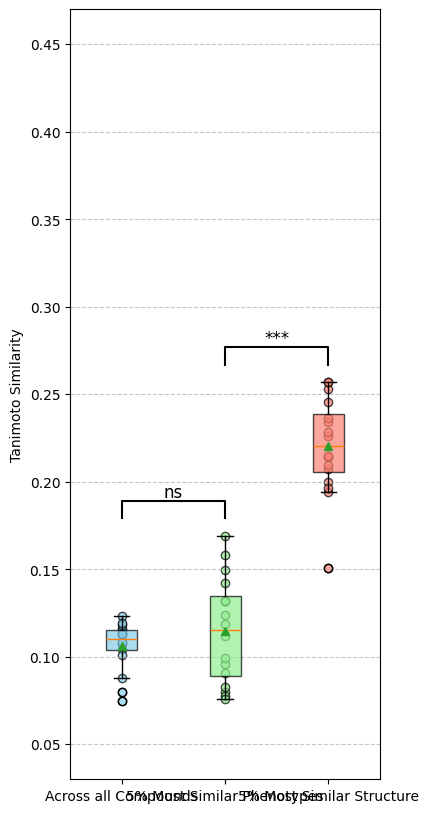

In [41]:

labels = ['Across all Compounds', '5% Most Similar Phenotypes', '5% Most Similar Structure']
colors = ['skyblue', 'lightgreen', 'salmon']

results = run_all_tests(np.array(all_means_Curie), np.array(top_5_means_Curie), np.array(high_5_means_Curie), alpha=0.05)

print("Statistical Test Results:")
for comp, res in results.items():
    print(f"\nComparison: {comp}")
    print(f"  Normality p-value: {res['Normality_p']:.10f}")
    print(f"  Test used: {res['Test']}")
    print(f"  Test Statistic: {res['Test_Statistic']:.10f}")
    print(f"  p-value: {res['p_value']:.10f}")
    print(f"  Cohen's d: {res['Cohen_d']:.4f}")

plot_results(all_means_Curie, top_5_means_Curie, high_5_means_Curie, labels, colors, results)


Statistical Test Results:

Comparison: High_vs_All
  Normality p-value: 0.2436110830
  Test used: paired t-test
  Test Statistic: 23.2947313786
  p-value: 0.0000000000
  Cohen's d: 3.1605

Comparison: High_vs_Top
  Normality p-value: 0.0125169596
  Test used: Wilcoxon signed-rank test
  Test Statistic: 1225.0000000000
  p-value: 0.0000000000
  Cohen's d: 2.9893

Comparison: Top_vs_All
  Normality p-value: 0.0000286625
  Test used: Wilcoxon signed-rank test
  Test Statistic: 549.0000000000
  p-value: 0.7361682603
  Cohen's d: 0.0319


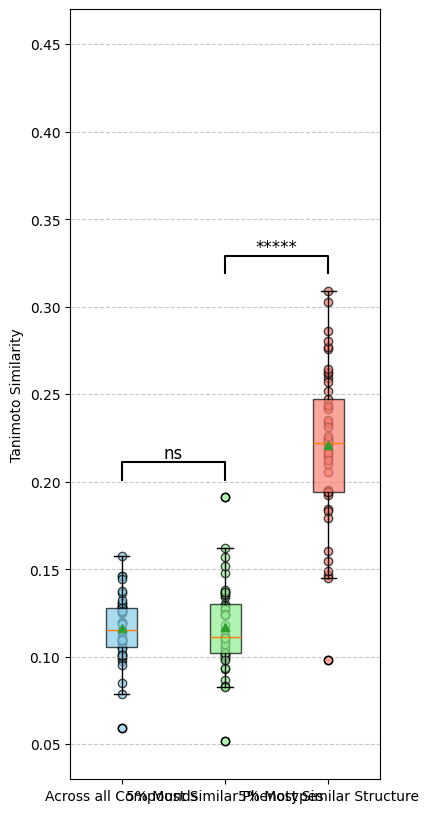

In [42]:


labels = ['Across all Compounds', '5% Most Similar Phenotypes', '5% Most Similar Structure']
colors = ['skyblue', 'lightgreen', 'salmon']

results = run_all_tests(np.array(all_means_ChemBL), np.array(top_5_means_ChemBL), np.array(high_5_means_ChemBL), alpha=0.05)

print("Statistical Test Results:")
for comp, res in results.items():
    print(f"\nComparison: {comp}")
    print(f"  Normality p-value: {res['Normality_p']:.10f}")
    print(f"  Test used: {res['Test']}")
    print(f"  Test Statistic: {res['Test_Statistic']:.10f}")
    print(f"  p-value: {res['p_value']:.10f}")
    print(f"  Cohen's d: {res['Cohen_d']:.4f}")

plot_results(all_means_ChemBL, top_5_means_ChemBL, high_5_means_ChemBL, labels, colors, results)


Statistical Test Results:

Comparison: High_vs_All
  Normality p-value: 0.0005551804
  Test used: Wilcoxon signed-rank test
  Test Statistic: 50005000.0000000000
  p-value: 0.0000000000
  Cohen's d: 4.2829

Comparison: High_vs_Top
  Normality p-value: 0.0040696502
  Test used: Wilcoxon signed-rank test
  Test Statistic: 50005000.0000000000
  p-value: 0.0000000000
  Cohen's d: 4.2612

Comparison: Top_vs_All
  Normality p-value: 0.0000000000
  Test used: Wilcoxon signed-rank test
  Test Statistic: 32323971.0000000000
  p-value: 0.0000000000
  Cohen's d: 0.0470


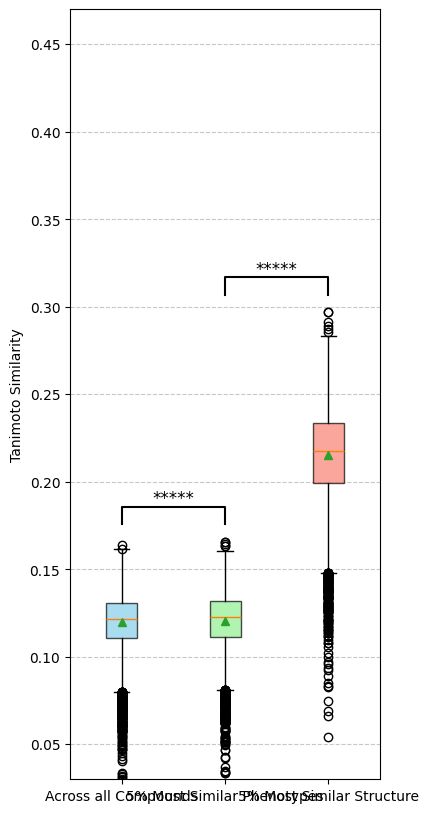

In [46]:

labels = ['Across all Compounds', '5% Most Similar Phenotypes', '5% Most Similar Structure']
colors = ['skyblue', 'lightgreen', 'salmon']

all_means_Jump = df_jump_clean['Avg_mean_Tanimoto'].to_list()
top_5_means_Jump = df_jump_clean['Avg_Cosine_Tanimoto'].to_list()
high_5_means_Jump = df_jump_clean['Avg_Morgan_Tanimoto'].to_list()



results = run_all_tests(np.array(all_means_Jump), np.array(top_5_means_Jump), np.array(high_5_means_Jump), alpha=0.05)

print("Statistical Test Results:")
for comp, res in results.items():
    print(f"\nComparison: {comp}")
    print(f"  Normality p-value: {res['Normality_p']:.10f}")
    print(f"  Test used: {res['Test']}")
    print(f"  Test Statistic: {res['Test_Statistic']:.10f}")
    print(f"  p-value: {res['p_value']:.10f}")
    print(f"  Cohen's d: {res['Cohen_d']:.4f}")

plot_results(all_means_Jump, top_5_means_Jump, high_5_means_Jump, labels, colors, results, False)
